# SmartBeds - Manifolds

## Grado en Ingeniería Informática
## Universidad de Burgos
##### José Luis Garrido Labrador

In [1]:
%matplotlib inline 
#para dibujar en el propio notebook
import pandas as pd # se importa pandas como pd
import numpy as np  #numpy como np
import matplotlib.pyplot as plt #%matplotlilib.pyplot como plt
import mpl_toolkits.mplot3d #Matplotlib 3d
import pickle as pk #Pikcle as pk
import gc #Garbage colector
from sys import getsizeof

## Lectura de datos

In [2]:
with open('data/datos.pdd','rb') as f:
    datos = pk.load(f)
    
datos_seizure = datos.loc[datos['target']==True]
datos_notSeizure = datos.loc[datos['target']==False]
getsizeof(datos)/2**20,getsizeof(datos_seizure)/2**20,getsizeof(datos_notSeizure)/2**20

(102.66939544677734, 0.1861133575439453, 102.48330497741699)

In [3]:
with open('data/datosE.pdd','rb') as f:
    dataE = pk.load(f)

dataE_seizure = dataE.loc[dataE['target']==True]
dataE_notSeizure = dataE.loc[dataE['target']==False]

## Particionado - Solo día de crisis

In [3]:
### Días donde hubo crisis
dayOfSeizures = set()

for i in datos_seizure['DateTime']:
    dayOfSeizures.add(i.date())


#Todos los datos de esos días
crit = datos['DateTime'].map(lambda x: x.date() in dayOfSeizures)

datosPart = datos[crit]
datosPart.head()
len(datosPart),getsizeof(datosPart)/2**20

(101106, 6.267465591430664)

In [4]:
data = datosPart.iloc[:,1:len(datosPart.columns)-1]
#data = data.astype(np.float32)
print(getsizeof(data)/2**20)
data.head()

5.399665832519531


,P1,P2,P3,P4,P5,P6
2067198,2.627311,31.002794,33.309522,41.181150,32.282415,16.554082
2067199,2.688000,30.898933,33.365262,41.342944,32.408223,16.539895
2067200,2.789683,30.790211,33.393760,41.480514,32.506432,16.520551
2067201,2.929013,30.678438,33.397692,41.597502,32.580526,16.497252
2067202,3.101846,30.565584,33.380283,41.697996,32.634364,16.471228


In [6]:
with open('data/datosDay.pdd','wb') as f:
    pk.dump(datosPart,f)

## Particionado - Cuarenta minutos alrededor de los crisis

In [5]:
## datosPart tiene lo días donde hubo ataques
# Cogemos la hora donde comenzó la crisis y cogemos 30 minutos antes
# Cogemos la hora donde terminó la crisis y cogemos 30 minutos despues
start = [] #Momentos en los que comenzó una crisis
stop = [] #Momentos en los que terminó una crisis

bi = datosPart.first_valid_index()
before = datosPart['target'][bi]
for index,row in datosPart.iterrows():
    if row['target'] and not before:
        start.append(row['DateTime'])
    elif not row['target'] and before:
        stop.append(datosPart['DateTime'][bi])
    before = row['target']
    bi = index
    
halfhour = 20*60

for i in range(len(start)):
    t = start[i]
    s = stop[i]
    start[i] = t-pd.to_timedelta(halfhour,unit='s')
    stop[i] = s+pd.to_timedelta(halfhour,unit='s')

start,stop

([Timestamp('2018-11-10 03:10:00')], [Timestamp('2018-11-10 04:10:00')])

In [6]:
masks = []
for i in range(len(start)):
    t = start[i]
    s = stop[i]
    masks.append(np.array([(datosPart['DateTime'] >= t) & (datosPart['DateTime'] <= s)],dtype=np.bool))

parts = []
mask=sum(masks)[0].astype(np.bool)
datosPartHour = datosPart.iloc[mask]

In [7]:
dataPH = datosPartHour.iloc[:,1:len(datosPartHour.columns)-1]
print(getsizeof(dataPH)/2**20)
#dataPH = dataPH.astype(np.float32)
dataPH.head()

0.480621337890625


,P1,P2,P3,P4,P5,P6
2095691,7.193204,33.305501,25.206553,31.323624,32.245622,20.934853
2095692,7.210681,33.310831,25.214016,31.334270,32.250765,20.940258
2095695,7.229248,33.316009,25.221059,31.344447,32.255317,20.945510
2095694,7.248841,33.321196,25.227688,31.354285,32.259463,20.950769
2095693,7.269367,33.326578,25.233951,31.363948,32.263429,20.956218


In [8]:
with open('data/datos20Min.pdd','wb') as f:
    pk.dump(datosPartHour,f)

## SpectralEmbedding

In [11]:
from sklearn.manifold import SpectralEmbedding as SE

### Datos brutos

In [15]:
seB = SE(n_components=2,n_neighbors=50).fit_transform(dataPH) #Con 50 vecinos no peta

In [ ]:
with open('data/spectalEmbedding.npy','wb') as f:
    pk.dump(seB,f)

Text(0.5, 1.0, 'Spectral Embedding Raw - Days of seizures')

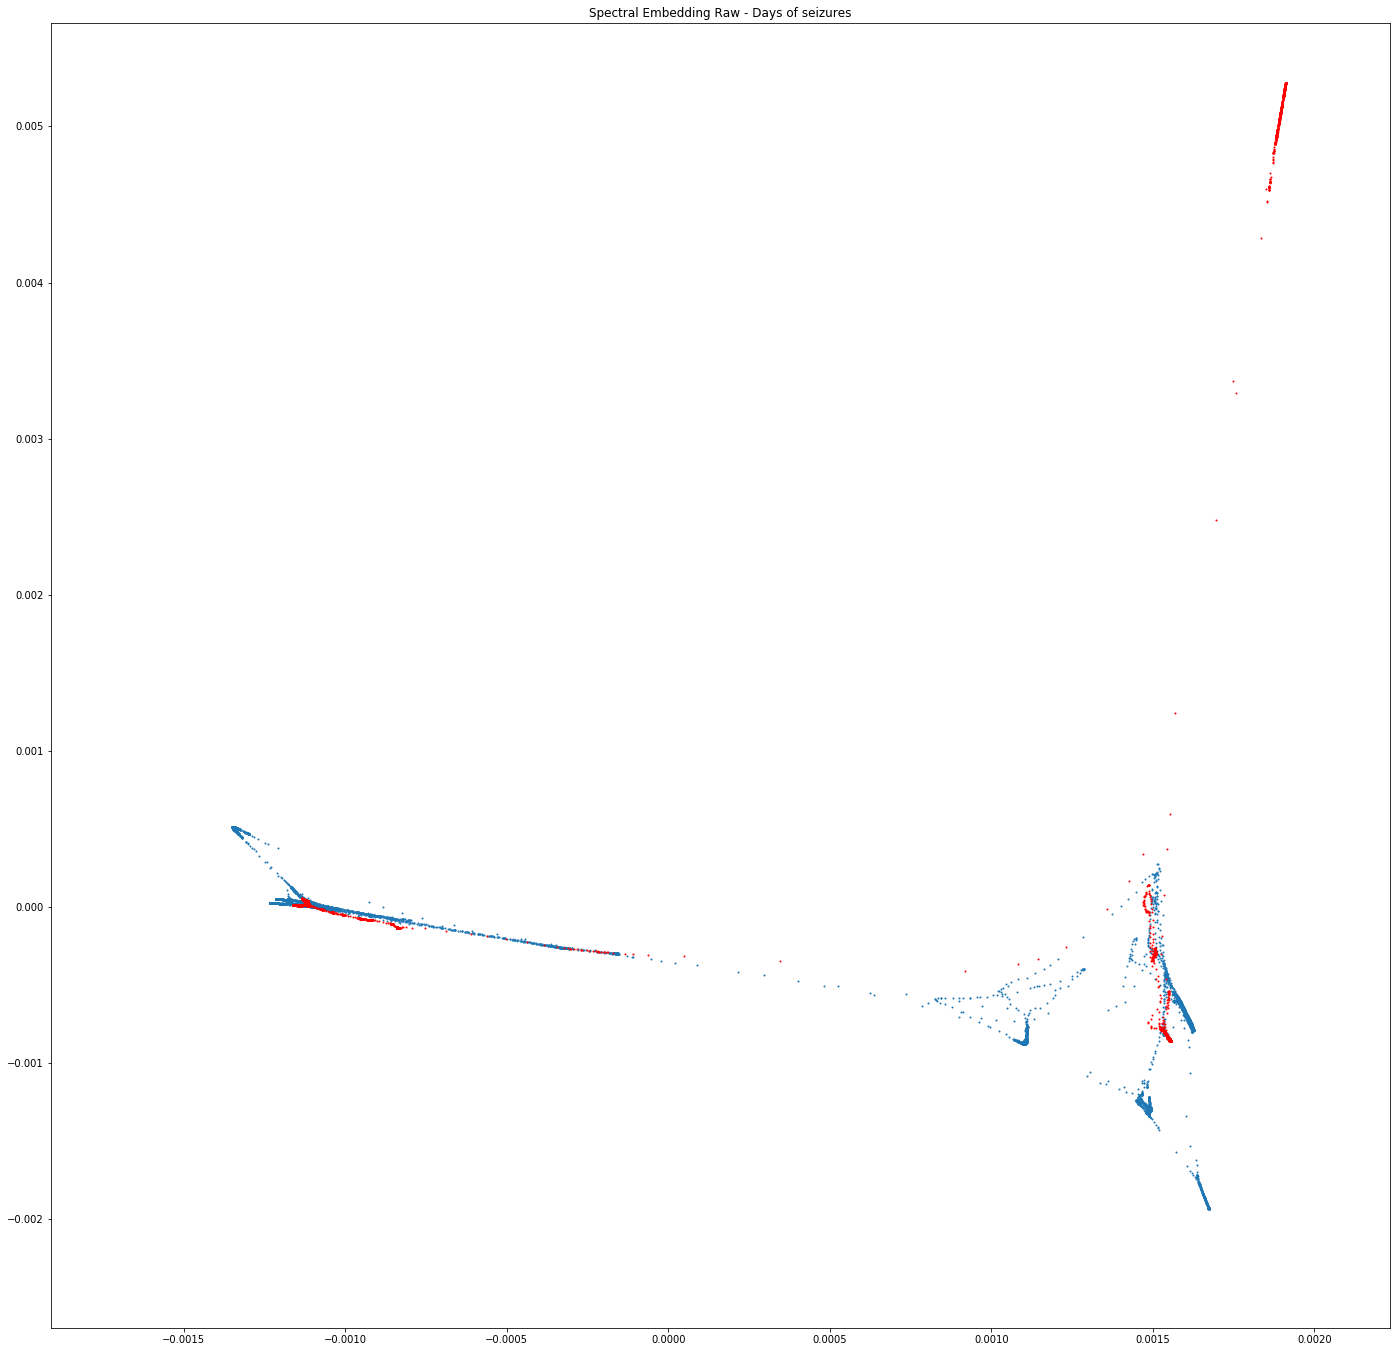

In [18]:
plt.figure(figsize=(24,24))
seSample = seB

target = datosPartHour['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(seSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('Spectral Embedding Raw - Days of seizures')


## t-SNE
*Linea de investigación desechada*

In [6]:
from tsnecuda import TSNE

### Datos Brutos

In [ ]:
tsneB = TSNE(n_components=2).fit_transform(data)

In [ ]:
plt.figure(figsize=(24,24))
tsneSample = tsneB

target = datosPart['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(tsneSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('t-SNE Raw - Days of seizures')

## MDS

In [10]:
from sklearn.manifold import MDS

### Datos Brutos

In [11]:
mdsB = MDS(n_components=2,max_iter=100).fit_transform(dataPH)

In [14]:
with open('data/MDS-raw-100.npy','wb') as f:
    pk.dump(mdsB,f)

Text(0.5, 1.0, 'MDS Raw - Days of seizures')

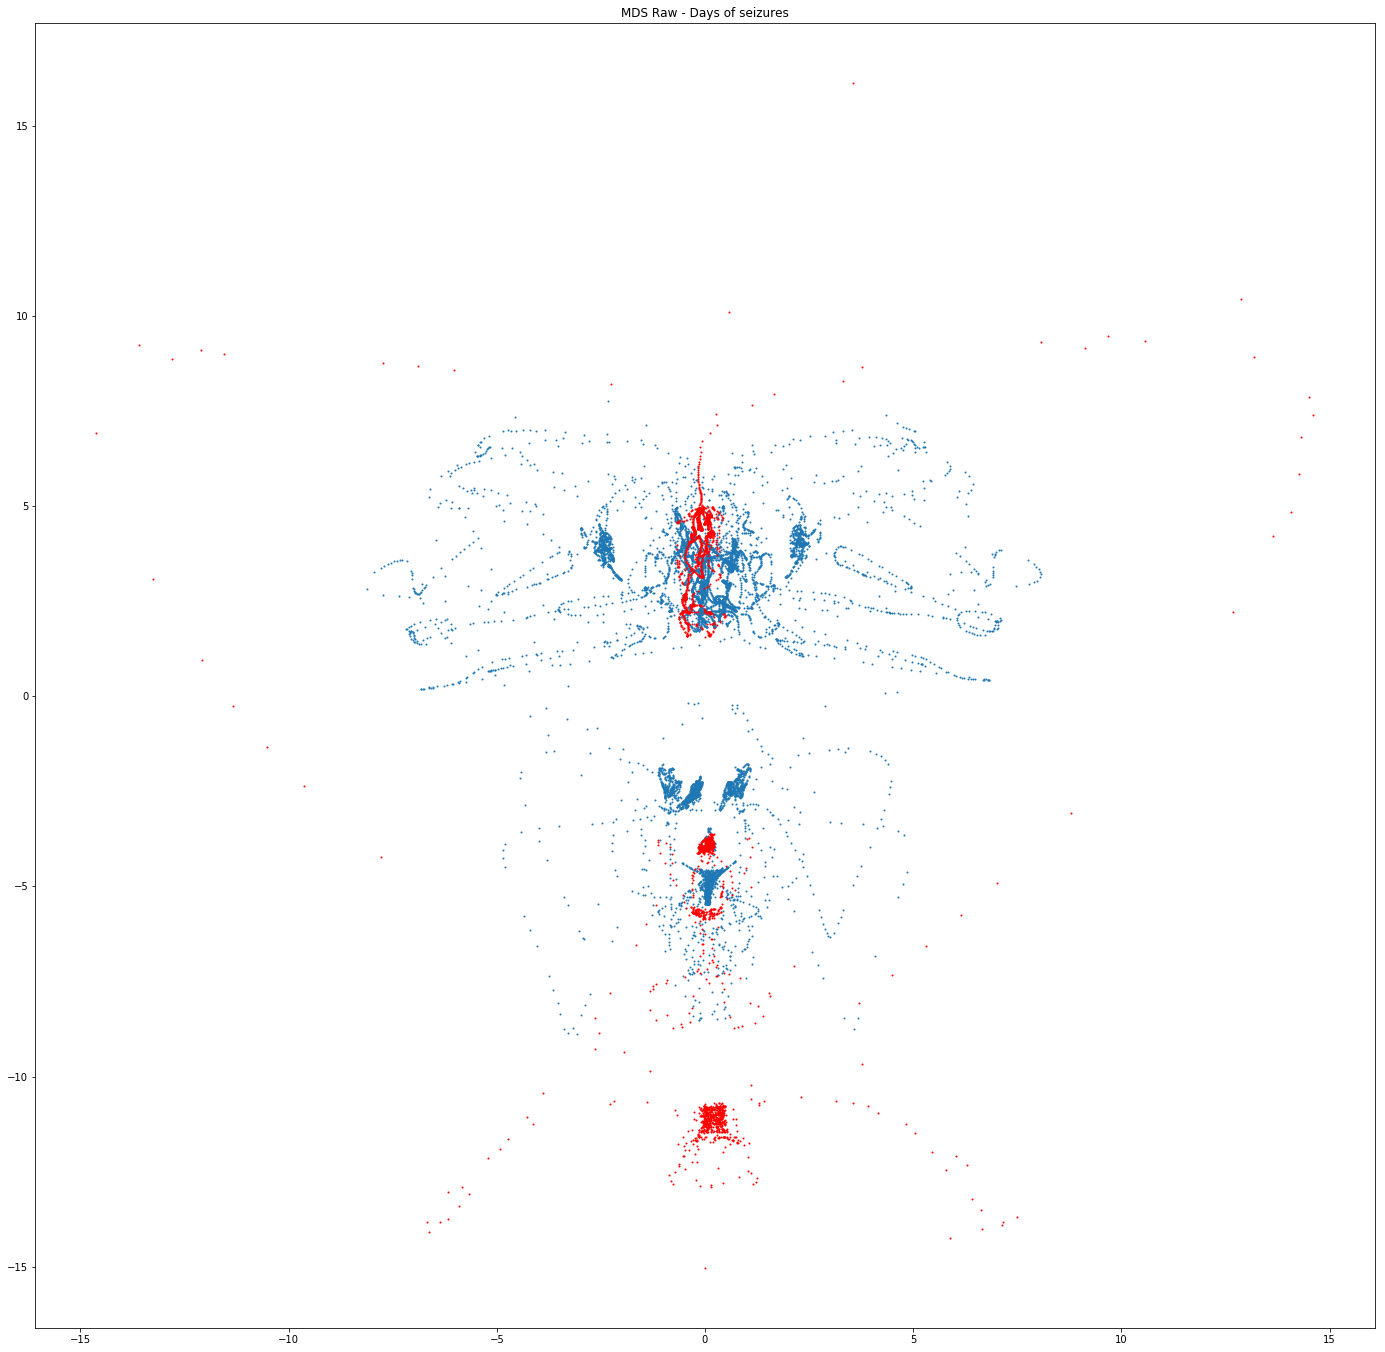

In [12]:
plt.figure(figsize=(24,24))
mdsSample = mdsB

target = datosPartHour['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(mdsSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('MDS Raw - Hour of seizures')

## LTSA

In [19]:
from sklearn.manifold import LocallyLinearEmbedding as LLE

### Datos Brutos

In [20]:
ltsaB = LLE(n_components=2,method='ltsa',n_neighbors=1000).fit_transform(dataPH)

In [22]:
with open('data/LTSA-raw-1000.npy','wb') as f:
    pk.dump(ltsaB,f)

Text(0.5, 1.0, 'LTSA Raw - Days of seizures')

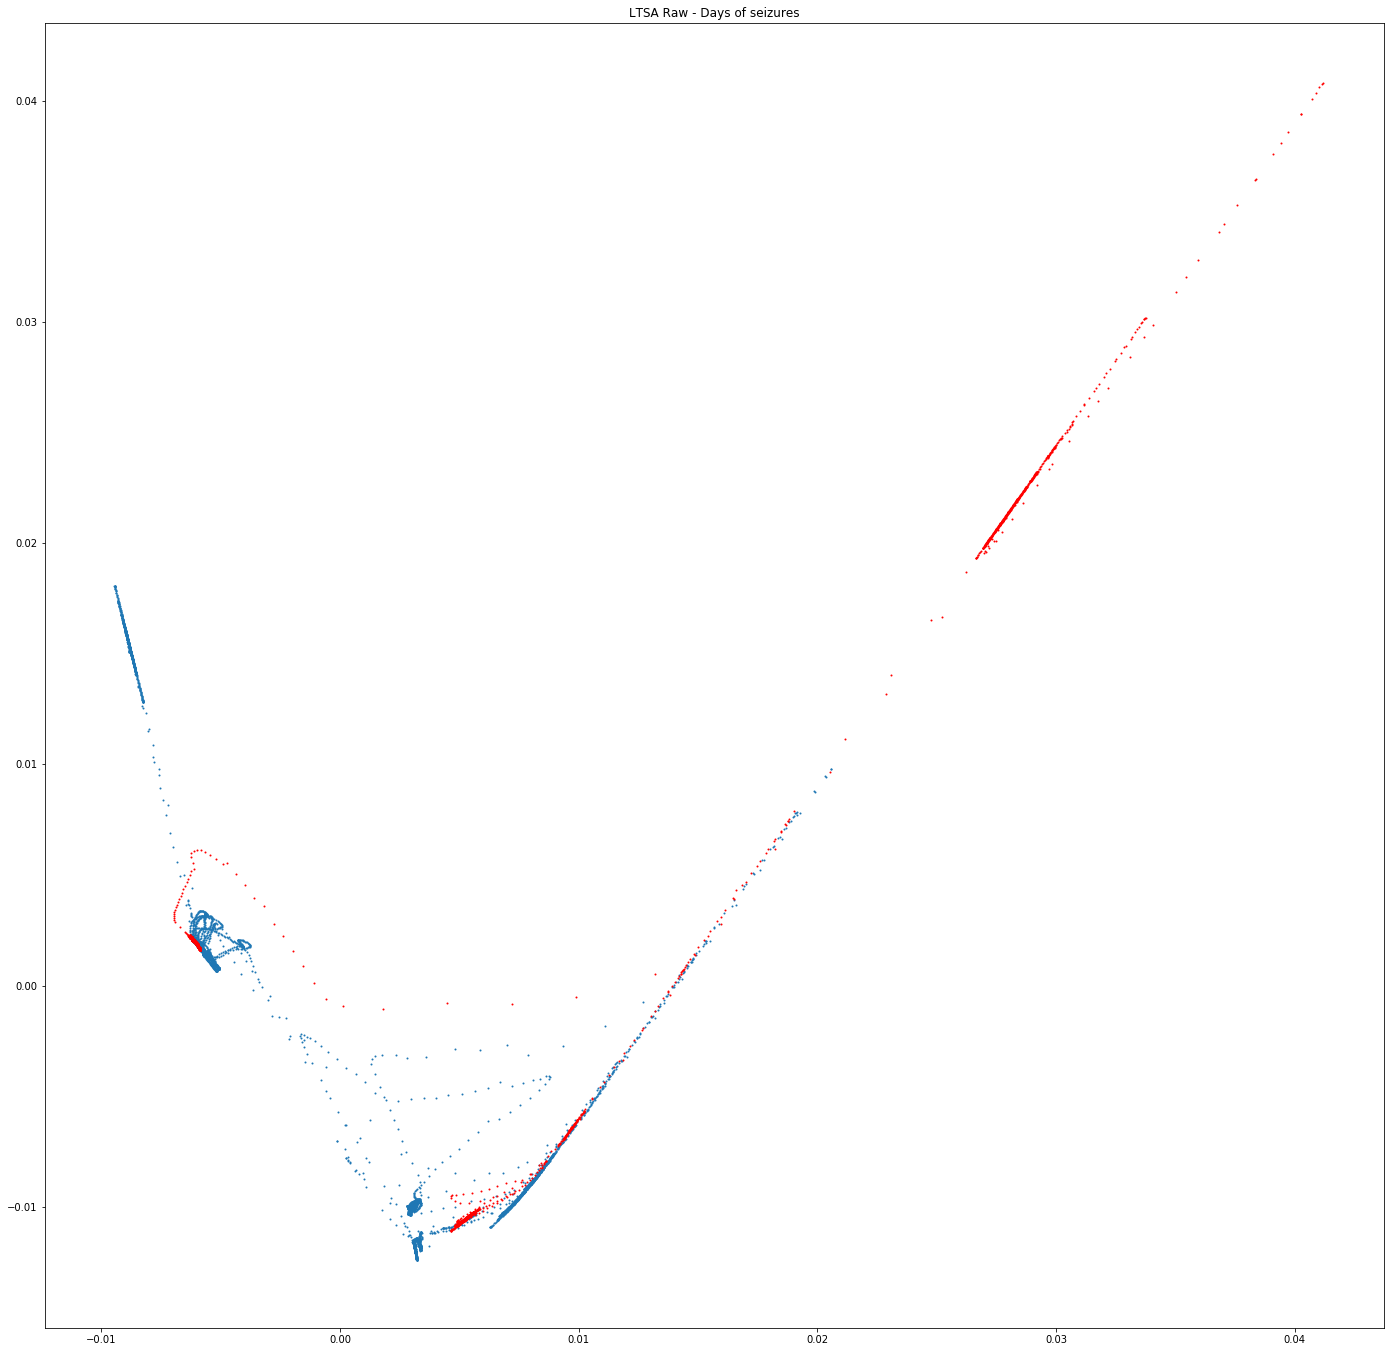

In [21]:
plt.figure(figsize=(24,24))
ltsaSample = ltsaB

target = datosPartHour['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(ltsaSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('LTSA Raw - Days of seizures')